In [7]:
# importing libraries

import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
sns.set()
pd.options.display.max_columns = None

In [9]:
# Importing data
cc_df = pd.read_excel("CreditCard.xls", header=1)
cc_df.rename(columns={"PAY_0":"PAY_1", "default payment next month":"DEFAULT"}, inplace=True)
cc_df.columns = [name.lower() for name in list(cc_df.columns)]
cc_df.drop(["id"], axis=1, inplace=True)

In [10]:
cc_df

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## Adding New Features

Based on my understanding of the data and conclusions from EDA, I engineer a few features

In [11]:
cc_df["avg_default"] = cc_df.iloc[:, 5:11].sum(axis=1)/6     #average default history
cc_df['avg_bill_amt'] = cc_df.iloc[:, 11:17].sum(axis=1) / 6   # average bill amount
cc_df['avg_pay_amt'] = cc_df.iloc[:, 18:24].sum(axis=1) / 6    # average payment amount
# There is some division by 0 in the following step. If I used this feature, I would need to address the situation.
cc_df['pay_bill_rat'] = cc_df['avg_pay_amt']/cc_df['avg_bill_amt'] # average payment to average bill ratio
cc_df['bill_bal_rat'] = cc_df['avg_bill_amt'] / cc_df['limit_bal'] # average bill amount to credit limit ratio
cc_df['pay_bal_rat'] = cc_df['avg_pay_amt'] / cc_df['limit_bal'] # average payment amount to credit limit ratio

In [12]:
print(cc_df['pay_bill_rat'].isna().sum()) # 0 divided by 0
print(cc_df[cc_df['pay_bill_rat']==np.inf].shape[0]) # non-zero divided by 0

499
371


In [13]:
cc_df.groupby("default")["avg_default"].mean()

default
0   -0.330023
1    0.337176
Name: avg_default, dtype: float64

In [14]:
cc_df.groupby("default")["avg_pay_amt"].mean()

default
0    4777.013882
1    2762.208258
Name: avg_pay_amt, dtype: float64

In [15]:
cc_df.groupby('default')['limit_bal'].mean()

default
0    178099.726074
1    130109.656420
Name: limit_bal, dtype: float64

In [16]:
cc_df[cc_df["avg_bill_amt"] != 0].groupby("default")["pay_bill_rat"].mean()


default
0    0.372585
1    0.220310
Name: pay_bill_rat, dtype: float64

In [17]:
cc_df.groupby('default')['bill_bal_rat'].mean()


default
0    0.351391
1    0.449298
Name: bill_bal_rat, dtype: float64

Having engineered the features, I see if some of the aggregated columns are correlated with default. A quick look does show some relation although I would have to do some statistical tests to see if that is significant.

I draw a scatter plot of average payment amount and average bill amount and notice that there is a marked difference in slope in the line of best fit for the default and non-default class.

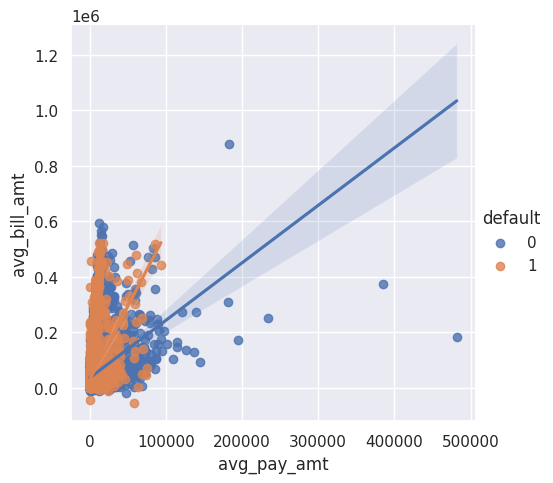

In [18]:
sns.lmplot(x="avg_pay_amt", y="avg_bill_amt", data=cc_df, hue="default")
fig = plt.gcf()
plt.show()

In [19]:
usage_labels = ["usage" + str(i) for i in range(1,7)]
pay_labels = ["pay_amt" + str(i) for i in range(1,7)]

# usage denotes the portion of credit limit paid in month 1
for i in range(0,6):
    cc_df[usage_labels[i]] = cc_df[pay_labels[i]] / cc_df["limit_bal"]
    
zero_bal_labels = ["zero_bal" + str(i) for i in range(1,7)]
bill_labels = ["bill_amt" + str(i) for i in range(1,7)]

# zero bal denotes the ratio of outstanding bill to credit limit
for i in range(0,6):
    cc_df[zero_bal_labels[i]] = (cc_df[bill_labels[i]] - cc_df[pay_labels[i]]) / cc_df['limit_bal']

In [20]:
cc_df[cc_df["avg_bill_amt"] > cc_df["limit_bal"]]["default"].value_counts()

0    419
1    218
Name: default, dtype: int64

I notice that about one third of the people whose average bill amount was more than the credit limit defaulted. As a result, I engineer a feature called overdraft which takes value 1 if the user defaulted at any point in the past 6 months.

In [21]:
cc_df['overdraft'] = np.where(
    (cc_df['bill_amt1'] > cc_df['limit_bal']) |
    (cc_df['bill_amt2'] > cc_df['limit_bal']) |
    (cc_df['bill_amt3'] > cc_df['limit_bal']) |
    (cc_df['bill_amt4'] > cc_df['limit_bal']) |
    (cc_df['bill_amt5'] > cc_df['limit_bal']) |
    (cc_df['bill_amt6'] > cc_df['limit_bal']), 1, 0
)

In [22]:
cc_df[cc_df["overdraft"] == 1]["default"].value_counts()

0    2748
1    1183
Name: default, dtype: int64

The original dataset had three categorical demographic variables (sex, marriage and education). Among them education has an ordinal structure as the changes in value lead to more or less education. sex had only two classes and so is already one-hot-encoded. I will now one-hot-encode the marriage variable.

In [23]:
# One hot encoding the marriage column and dropping the first column

j = cc_df.columns.get_loc("marriage")

left = cc_df.iloc[:, :j]
marriage = pd.get_dummies(cc_df["marriage"], prefix="marriage", drop_first=True)
right = cc_df.iloc[: , j+1:]

cc_df = pd.concat([left, marriage, right], axis=1)

### Feature selection, scaling, splitting and balancing the data

In [27]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [36]:
def make_stratified_tts(df: pd.DataFrame, features: list, target: str ="default", scaled: bool = False, balanced: bool = False, test_size: float = 0.2, random_state: int = 1) -> pd.DataFrame:
    """
    This function take in a dataframe, the features variables, the target variables
    and then splits the data with the user having the option to scale and balance the data
    and set values for the split proportion and the random seed.
    """
    #Resampling method
    random_os = RandomOverSampler()     #Oversampling
    smote = SMOTE()      #smsote
    
    X, y = df[features], df[target]
    
    #checking if X needs to be scaled
    if scaled == True:
        X_sc = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)
    else:
        X_sc = X
        
    # Train-test split
    X_sc_train, X_sc_test, y_train, y_test = train_test_split(
    X_sc, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    # Checking if training data needs to be balanced
    if balanced == "random_os":
        X_sc_train_rs, y_sc_train_rs = random_os.fit_resample(X_sc_train, y_train)
    elif balanced == 'smote':
        X_sc_train_rs, y_sc_train_rs = smote.fit_resample(X_sc_train, y_train)
    else:
        X_sc_train_rs, y_sc_train_rs = X_sc_train, y_train        
        
    return X_sc_train_rs, X_sc_test, y_sc_train_rs, y_test

This is the original data set, along with some minor data adjustments discussed earlier and the one-hot encoding of the marriage feature.

In [37]:
features_1 = list(cc_df.columns[:25])
X1_train, X1_test, y_train, y_test = make_stratified_tts(cc_df, features_1)
print(features_1)
X1 = cc_df[features_1]

['limit_bal', 'sex', 'education', 'marriage_1', 'marriage_2', 'marriage_3', 'age', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']


This dataset contains features that avoid multicollinearity in the model (and hence, statistically significant non-zero coefficients in a logistic model). I decide on this list by looking at the vif and deviance reduction and also at the feature importances of the models. The dataset is then scaled and the training set balanced.

In [38]:
features_best = (
    list(cc_df.columns[0:5])
    + list(cc_df.columns[6:12])
    + list(cc_df.columns[18:24])
    + [cc_df.columns[25]]
    + [cc_df.columns[27]]
    + list(cc_df.columns[31: 34])
    + [cc_df.columns[36]]
    + list(cc_df.columns[38: 40])
    + [cc_df.columns[42]]
)

X3_sc_train_rs1, X3_sc_test, y3_sc_train_rs1, y_test = make_stratified_tts(cc_df, features_best, scaled=True, balanced='smote')
X3_sc_train_rs2, X3_sc_test, y3_sc_train_rs2, y_test = make_stratified_tts(cc_df, features_best, scaled=True, balanced='random_os')
print(features_best)
X3 = cc_df[features_best]

['limit_bal', 'sex', 'education', 'marriage_1', 'marriage_2', 'age', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'default', 'avg_bill_amt', 'pay_bal_rat', 'usage1', 'usage2', 'usage5', 'zero_bal1', 'zero_bal2', 'zero_bal5']


In [41]:
def plot_feat_imp(X_train: pd.DataFrame, model:object):
    """
    Prints the model feature importances
    """
    feat_imp = pd.DataFrame(
        {"Feature": X_train.columns, "Feature Importance": model.feature_importances_}
    )
    feat_imp.sort_values(by="Feature Importance", ascending=False, inplace=True)
    plt.figure(figsize=(15, 10))
    plt.title(f"Feature Importance of {model}", fontsize=14)
    ax = sns.barplot(x="Feature", y="Feature Importance", data=feat_imp)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

NameError: name 'obj' is not defined

In [ ]:
def get_model_results(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test:pd.Series, model: object, feat_imp: bool = False):
    """
    Prints the training and test metrics and plots the confusion metrices.
    Also plots the feature importance based on the user choosing the parameter variable
    and returns the evaluation metrics.
    """
    # Fit training model to training set
    model.fit(X_train, y_train)
    
    # Obtain the predicted values and probabilities from the model
    y_train_pred = model.predict(X_train)
    y_train_pred_probs = model.predict_proba(X_train)
    
    y_test_pred = model.predict(X_test)
    y_test_pred_probs = model.predict_proba(X_test)
    
    # Get confusion matrix
    train_matrix = metrics.confusion_matrix(y_train, y_train_pred)
    test_matrix = metrics.confusion_matrix(y_test, y_test_pred)

    # Get F1 score
    f1_train = metrics.f1_score(y_train, y_train_pred)
    f1_test = metrics.f1_score(y_test, y_test_pred)

    # Print the train and test roc_auc_score
    #and test confusion matrix
    print(
        f"ROC_AUC_Score of train set is {metrics.roc_auc_score(y_train, y_train_pred_probs[:, 1])}."
    )
    print(
        f"ROC_AUC_Score of test set is {metrics.roc_auc_score(y_test, y_test_pred_probs[:, 1])}."
    )
    
    # Display scores
    print(f"F1 of train set is {f1_train.round(4)}.")
    print(f"F1 of test set is {f1_test.round(4)}.")

    # Plot training and test confusion matrices
    plt.figure(figsize=(12, 4))
    names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    train_percent = [
        "{0:.2%}".format(value)
        for value in train_matrix.flatten() / np.sum(train_matrix)
    ]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(names, train_percent)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.subplot(1, 2, 1)
    sns.heatmap(train_matrix, annot=labels, fmt="", cmap="Blues")
    plt.title("Train Set\n")

    names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    test_percent = [
        "{0:.2%}".format(value) for value in test_matrix.flatten() / np.sum(test_matrix)
    ]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(names, test_percent)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.subplot(1, 2, 2)
    sns.heatmap(test_matrix, annot=labels, fmt="", cmap="Blues")
    plt.title("Test Set\n")

    plt.subplots_adjust(wspace=0.2)


    if feat_imp == True:
        plot_feat_imp(X_train, model)
    elif feat_imp == "LR":
        # Get feature coefficients
        importance = model.coef_[0]

        df_feat_imp = pd.DataFrame(
            columns=["Feature", "Feature Importance (Value of Coefficient)"]
        )
        
        # Attach feature coefficients to labels
        for i, v in enumerate(importance):
            df_feat_imp = df_feat_imp.append(
                {
                    "Feature": X_train.columns[i],
                    "Feature Importance (Value of Coefficient)": v,
                },
                ignore_index=True,
            )

            #print(f"{X_train.columns[i]} Feature: %0d, Score: %.5f" % (i, v))
        
        # Sort them by their absolute values in descending order
        df_feat_imp = df_feat_imp.reindex(
            df_feat_imp["Feature Importance (Value of Coefficient)"]
            .abs()
            .sort_values(ascending=False)
            .index
        )
        
        # Plot a bargraph
        plt.figure(figsize=(10, 5))
        plt.title(f"Feature Importance of {model}", fontsize=14)
        ax = sns.barplot(x="Feature", y="Feature Importance (Value of Coefficient)", data=df_feat_imp)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.show()
        
    else:
        pass
    
    return metrics.accuracy_score(y_test, y_test_pred),\
           metrics.precision_score(y_test, y_test_pred),\
           metrics.recall_score(y_test, y_test_pred),\
           metrics.f1_score(y_test, y_test_pred),\
           metrics.roc_auc_score(y_test, y_test_pred_probs[:, 1])
    
    